In [1]:

%matplotlib inline
from itertools import chain
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any

from matplotlib import pyplot as plt


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-10-09 05:18:53.505239: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 05:18:53.628121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 05:18:53.628184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 05:18:53.651577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 05:18:53.701379: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 05:18:53.702272: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [4]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [5]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

05:18:56 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/ovarian_model.stan to exe file /home/josh/workspace/bayesianquilts/ovarian_model
05:19:13 - cmdstanpy - INFO - compiled model executable: /home/josh/workspace/bayesianquilts/ovarian_model


In [6]:
guessnumrelevcov = N / 10  # 20.
slab_scale = 2.5
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))

control = {"adapt_delta": 0.9999, "max_treedepth": 15}

# shuffle

# shuffled_ndx = np.random.shuffle(np.arange(N))

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json

with open("ovarian_data.json", "w") as f:
    json.dump(ovarian_data, f)

In [7]:
print(d)

1536


In [8]:
S = 1800
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=15000,
    iter_sampling=S,
    thin=2,
    **control
)

05:19:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

05:43:52 - cmdstanpy - INFO - CmdStan done processing.
05:43:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[137] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[93] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Consider re-running with show_console=True if the above output is unclear!


05:43:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [9]:
print(fit)

CmdStanMCMC: model=ovarian_model chains=4['method=sample', 'num_samples=1500', 'num_warmup=15000', 'thin=2', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.9995']
 csv_files:
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_1.csv
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_2.csv
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_3.csv
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_4.csv
 output_files:
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_0-stdout.txt
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_1-stdout.txt
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_2-stdout.txt
	/tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_3-stdout.txt


In [10]:
print(fit.diagnose())

Processing csv files: /tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_1.csv, /tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_2.csv, /tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_3.csv, /tmp/tmpbt2atxq1/ovarian_modelv159bofb/ovarian_model-20241009051913_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 3000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [11]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]


In [12]:

c = slab_scale * tf.math.sqrt(params["caux"])
lambda_tilde = tf.math.sqrt(
    c**2
    * params["lambda"] ** 2
    / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
)
beta_fitted = params["z"] * lambda_tilde * params["tau"]
beta_fitted.shape

TensorShape([3000, 1536])

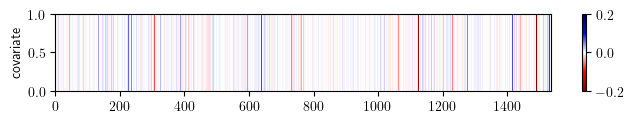

In [13]:
beta_fitted = np.mean(beta_fitted, axis=0, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
im = ax.pcolormesh(beta_fitted, cmap='seismic_r', vmin=-0.2, vmax=0.2)
_ = plt.ylabel("covariate")

plt.colorbar(im)
plt.savefig("ovarian_mcmc_fit.pdf", bbox_inches='tight')

In [14]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [15]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00,  2.30it/s]


(0.0, 1.0)

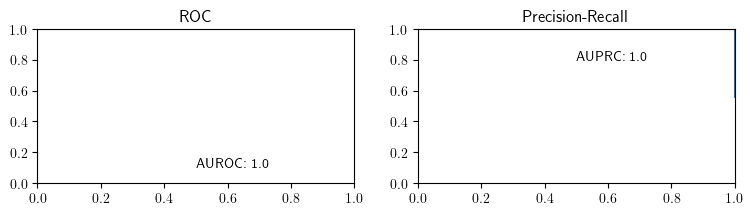

In [16]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [54]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(
    self: LogisticRegression2,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = beta[..., tf.newaxis, :] * _X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]



    # log-likelihood descent

    def T_ll(X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma

        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl(X, y):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_I(X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = tf.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var(X, y):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_mean(X, y):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param, axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            return hat, hat_w

        beta_hat, beta_hat_w = theta_hat(beta)
        beta0_hat, beta0_hat_w = theta_hat(params["beta0"])

        dbeta = -beta_hat + beta_hat_w
        dbeta0 = -beta0_hat + beta0_hat_w

        beta_adj = beta[:, tf.newaxis, ...] + dbeta
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + dbeta0

        J = 1 - 1 / tf.reduce_sum(tf.ones_like(c)) + tf.reduce_sum(weights, axis=-1)

        # shift by mean
        return beta_adj, beta0_adj, tf.math.log(J)

    def T_moment(X, y):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat)**2)
            v_w = tf.reduce_sum(weights*(param[:, tf.newaxis, ...] - hat)**2, axis=0, keepdims=True)
            return hat, hat_w, v, v_w
        

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        beta_adj = tf.math.sqrt(beta_v_w/beta_v) * (beta[:, tf.newaxis, ...] - beta_hat) + beta_hat_w
        beta0_adj = tf.math.sqrt(beta0_v_w/beta0_v) * (params["beta0"][:, tf.newaxis, ...] - beta0_hat) + beta0_hat_w

        J = 1 - 1 / tf.reduce_sum(tf.ones_like(c)) + tf.reduce_sum(weights, axis=-1)

        # shift by mean
        return beta_adj, beta0_adj, tf.math.log(J)

    def IS(T, X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = tf.concat(
                [
                    -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                    / self.surrogate_distribution.model["intercept__"].variance(),
                    -(beta - self.surrogate_distribution.model["beta__"].mean())
                    / self.surrogate_distribution.model["beta__"].variance(),
                ],
                axis=-1,
            )

            log_pi = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            ) + self.surrogate_distribution.model["intercept__"].log_prob(
                params["intercept__"]
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob_parts(params)
            log_prior = log_prior["z"] + log_prior["beta0"]

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

            # pi \propto
            grad_log_pi = tf.concat(
                [
                    tf.reduce_sum(log_ell_prime[..., tf.newaxis], axis=1, keepdims=True),
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                    ),
                ],
                axis=-1,
            )

            grad_log_prior = -0.5 * tf.concat(
                [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
                axis=-1,
            )
            grad_log_pi += grad_log_prior[:, tf.newaxis, :]
        
        beta_new, intercept_new, logJ = T(X, y)
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        log_eta_weights = delta_log_pi - log_ell_new + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )
    X_ = tf.gather(_X, ndx_to_leave) 
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
                "p_loo": p_loo_I,
                "p_loo_sd": p_loo_I_sd,
                "ll_loo": ll_loo_I,
                "ll_loo_sd": ll_loo_I_sd,
                "S": S_I,
                "khat": k_I,
                "p_psis": p_psis_I,
                "ll_psis": ll_psis_I,
                "ndx": ndx_to_leave
            }
    }
    
    transforms ={
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        "LL": T_ll,
        "MM": T_moment,
    }
    
    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)
        
        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    lr_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var", "MM"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

NameError: name 'log_pi' is not defined

In [37]:
base = 4
h_vals = [4**-r for r in range(9)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [500, 1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I", "LL", "KL", "Var", "MM"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx)

100%|██████████| 1/1 [03:14<00:00, 194.51s/it]

{500: {1: {'I': [], 'LL': [], 'KL': [], 'Var': [44], 'MM': []}, 0.25: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 0.0625: {'I': [], 'LL': [8, 25, 39, 44, 53], 'KL': [], 'Var': [], 'MM': []}, 0.015625: {'I': [], 'LL': [39, 49, 50, 53], 'KL': [], 'Var': [], 'MM': []}, 0.00390625: {'I': [], 'LL': [49], 'KL': [], 'Var': [], 'MM': []}, 0.0009765625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 0.000244140625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 6.103515625e-05: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 1.52587890625e-05: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}}, 1000: {1: {'I': [], 'LL': [1, 7], 'KL': [], 'Var': [], 'MM': []}, 0.25: {'I': [], 'LL': [1], 'KL': [], 'Var': [], 'MM': []}, 0.0625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 0.015625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 0.00390625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 0.0009765625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}, 0.00024

In [42]:
reduced_ndx

{500: {1: {'I': [], 'LL': [], 'KL': [], 'Var': [44], 'MM': []},
  0.25: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  0.0625: {'I': [], 'LL': [8, 25, 39, 44, 53], 'KL': [], 'Var': [], 'MM': []},
  0.015625: {'I': [], 'LL': [39, 49, 50, 53], 'KL': [], 'Var': [], 'MM': []},
  0.00390625: {'I': [], 'LL': [49], 'KL': [], 'Var': [], 'MM': []},
  0.0009765625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  0.000244140625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  6.103515625e-05: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  1.52587890625e-05: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []}},
 1000: {1: {'I': [], 'LL': [1, 7], 'KL': [], 'Var': [], 'MM': []},
  0.25: {'I': [], 'LL': [1], 'KL': [], 'Var': [], 'MM': []},
  0.0625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  0.015625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  0.00390625: {'I': [], 'LL': [], 'KL': [], 'Var': [], 'MM': []},
  0.0009765625: {'I': [], 'LL': [], 'KL': [], 'V

In [39]:
df = pd.DataFrame(records)
df['rho_rank'] = np.emath.logn(base, df['h']) 
df


,h,T,S,khat,p_psis,n>0.7,ndx,rho_rank
0,1.000000,I,500,"[0.8996723641656623, 1.0036552450745986, 0.877...","[0.2830992111188045, 0.02827372414202521, 0.02...","(30,)","[0, 6, 8, 10, 15, 21, 23, 24, 25, 26, 28, 29, ...",0.0
1,1.000000,LL,500,"[1.052365672204834, 1.066936917814332, 0.84311...","[0.00018774218952721496, 4.6239321874000816e-0...","(30,)","[0, 6, 8, 10, 15, 21, 23, 24, 25, 26, 28, 29, ...",0.0
2,1.000000,KL,500,"[0.9311681500559388, 1.1229131927956992, 1.000...","[0.24953179604394873, 0.012136476181740375, 0....","(30,)","[0, 6, 8, 10, 15, 21, 23, 24, 25, 26, 28, 29, ...",0.0
3,1.000000,Var,500,"[0.898724233749608, 0.9317822021262441, 0.8843...","[0.25712122924135794, 0.018598154699416482, 0....","(29,)","[0, 6, 8, 10, 15, 21, 23, 24, 25, 26, 28, 29, ...",0.0
4,1.000000,MM,500,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[nan, nan, nan, nan, nan, nan, nan, 0.00175882...","(30,)","[0, 6, 8, 10, 15, 21, 23, 24, 25, 26, 28, 29, ...",0.0
...,...,...,...,...,...,...,...,...
85,0.000015,I,1000,"[0.7857181441240992, 0.9988713199794041, 0.947...","[0.3177854342291608, 0.39075950431301487, 0.03...","(36,)","[1, 3, 6, 7, 12, 15, 17, 18, 19, 21, 23, 25, 2...",-8.0
86,0.000015,LL,1000,"[0.9469483890533887, 1.076120287894048, 0.9516...","[0.2986991287676004, 0.40552768704404213, 0.03...","(36,)","[1, 3, 6, 7, 12, 15, 17, 18, 19, 21, 23, 25, 2...",-8.0
87,0.000015,KL,1000,"[0.7850081761158265, 1.0001864386632353, 0.948...","[0.31783118102340224, 0.3907802881380385, 0.03...","(36,)","[1, 3, 6, 7, 12, 15, 17, 18, 19, 21, 23, 25, 2...",-8.0
88,0.000015,Var,1000,"[0.7856645885713671, 0.9990938808542957, 0.947...","[0.3178258059762198, 0.39079575532108707, 0.03...","(36,)","[1, 3, 6, 7, 12, 15, 17, 18, 19, 21, 23, 25, 2...",-8.0


In [40]:
kl_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="KL")]
var_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="LL")]
I_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I")]

kl_ = kl_.explode(['khat', 'ndx'])
var_ = var_.explode(['khat', 'ndx'])
ll_ = ll_.explode(['khat', 'ndx'])
I = I_.explode(['khat', 'ndx'])


In [41]:
recode = dict(zip(kl_['ndx'].unique(),np.arange(len(kl_['ndx'].unique())),))
kl_ = kl_.replace({"khat>0.7": recode})
var_ = var_.replace({"khat>0.7": recode})
ll_ = ll_.replace({"khat>0.7": recode})
I_ = I_.replace({"khat>0.7": recode})

In [35]:
fig = plt.figure(figsize=(4, 6))
ymax = (len(high_ndx_))
#_ = plt.scatter( dfI["khat_high"], dfI["khat>0.7"],color="black", s=12, alpha=0.3)
_ = plt.scatter(kl_.khat_high, kl_['khat>0.7'] + 0.2, s=1, color='green', alpha=0.3)
_ = plt.scatter(var_.khat_high, var_['khat>0.7'] - 0.2, s=1, color='purple', alpha=0.3)

kl_ = kl_[kl_.khat_high<3]
ll_ = ll_[ll_.khat_high<3]
var_ = var_[var_.khat_high<3]
_ = plt.axvline(x=0.7, linestyle='dashed', linewidth=2, color='red', alpha=0.5)

kl_vals = defaultdict(list)
var_vals = defaultdict(list)
ll_vals = defaultdict(list)

for x, y, s in zip( kl_.khat_high, kl_['khat>0.7'] + 0.2, kl_['hrank'].values.astype('int')):
    kl_vals[y] += [x]
    
for x, y, s in zip( var_.khat_high, var_['khat>0.7']-0.2, var_['hrank'].values.astype('int')):
    var_vals[y] += [x]

for x, v in kl_vals.items():
    plt.text(min(v), x, "KL",  ha='center', va='center', color='green', fontsize=8)
    
for x, v in var_vals.items():
    plt.plot(min(v), x, color='purple', alpha=0.3)
    plt.text(min(v), x, "Var",  ha='center', va='center', color='blue', fontsize=8)
    
    
for x, v in var_vals.items():
    plt.text(min(v), x, "LL",  ha='center', va='center', color='purple', fontsize=8)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=ndx)
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat.pdf", bbox_inches='tight')

NameError: name 'high_ndx_' is not defined

<Figure size 400x600 with 0 Axes>

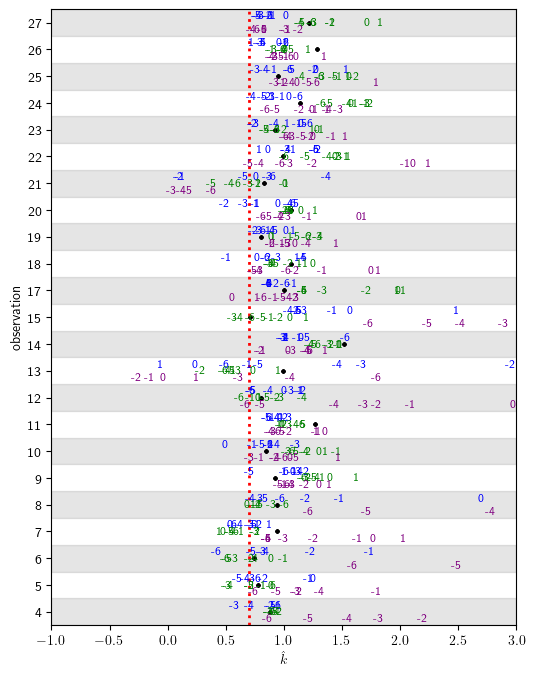

In [161]:
fig = plt.figure(figsize=(6, 8))
ymax = (len(high_ndx_))
_ = plt.scatter( dfI["khat_high"], dfI["khat>0.7"],color="black", s=3)
_ = plt.scatter(kl_.khat_high, kl_['khat>0.7'], s=0)
_ = plt.scatter(ll_.khat_high, ll_['khat>0.7'], s=0)
_ = plt.scatter(var_.khat_high, var_['khat>0.7'], s=0)

kl_ = kl_[kl_.khat_high<3]
ll_ = ll_[ll_.khat_high<3]
var_ = var_[var_.khat_high<3]
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=2, color='red')

for x, y, s in zip( kl_.khat_high, kl_['khat>0.7'] + 0.25, kl_['hrank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, y, str(s),  ha='center', va='center', color='blue', fontsize=8)
    
for x, y, s in zip( var_.khat_high, var_['khat>0.7'], var_['hrank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, y, str(s),  ha='center', va='center', color='green', fontsize=8)

for x, y, s in zip( ll_.khat_high, ll_['khat>0.7'] - 0.25, ll_['hrank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, y, str(s),  ha='center', va='center', color='purple', fontsize=8)
    
_ = plt.yticks(ticks=np.arange(ymax), labels=ndx)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'$\hat{k}$')

_ = plt.xlim((-1, 3))


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_detailed.pdf", bbox_inches='tight')

In [162]:
len(df[['khat', "p_psis", 'ndx']].iloc[0, :].values[0]), len(ndx)

(29, 23)

In [163]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
df_ = df_.groupby('ndx')[['khat', 'p_psis']].min()
ok_ndx = df_[df_.khat<0.7].index

ValueError: columns must have matching element counts

In [90]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
df_ = df_.groupby('ndx')[['khat', 'p_psis']].min()
ok_ndx = df_[df_.khat<0.7].index

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y__[ok_ndx], df_.iloc[ok_ndx, :].p_psis, pos_label=1)


ValueError: columns must have matching element counts

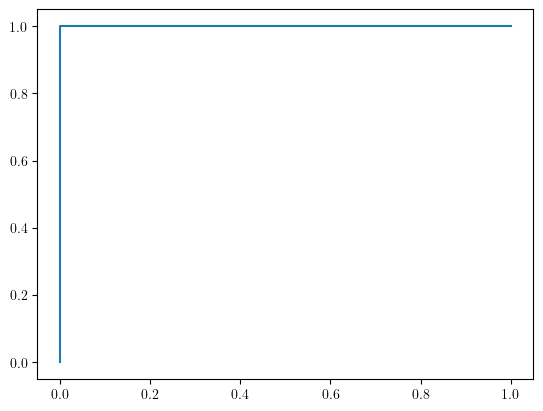

In [107]:
plt.plot(fpr, tpr)

In [108]:
step_size = 1e-3
def prediction_fn_stepaway(data):
    loo = adaptive_is_loo(lr_model, data, params, step_size, variational=False)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    pred = adaptive_is_loo(lr_model, data, params, step_size, variational=False)["LL"]['p_loo']
    return pred



In [109]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



1it [00:06,  6.39s/it]
1it [00:06,  6.20s/it]


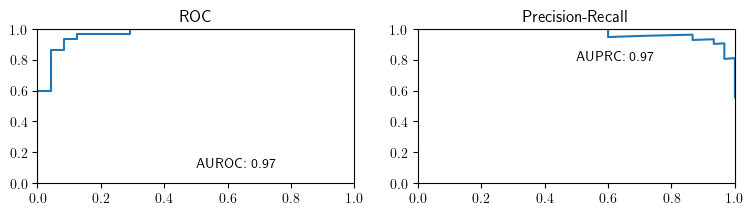

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig('roc_mcmc.pdf', bbox_inches='tight')

# Compare with variational model

In [62]:
lr_model2 = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)